Exercício - Dataset Diabetes  
=============================

In [29]:
%load_ext autoreload
%autoreload 2

from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import KMeansSMOTE
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import sys
import platform

sys.path.insert(1, '../')

from src.plot import plot_heatmap
from src.train import get_all_subsets, results_regression

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('./../../Datasets/diabetes.csv')

In [3]:
data.shape

(768, 9)

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Missing values
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# duplicates
data.duplicated().sum()

0

In [7]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [8]:
data_correlation = data.corr()
data_correlation

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


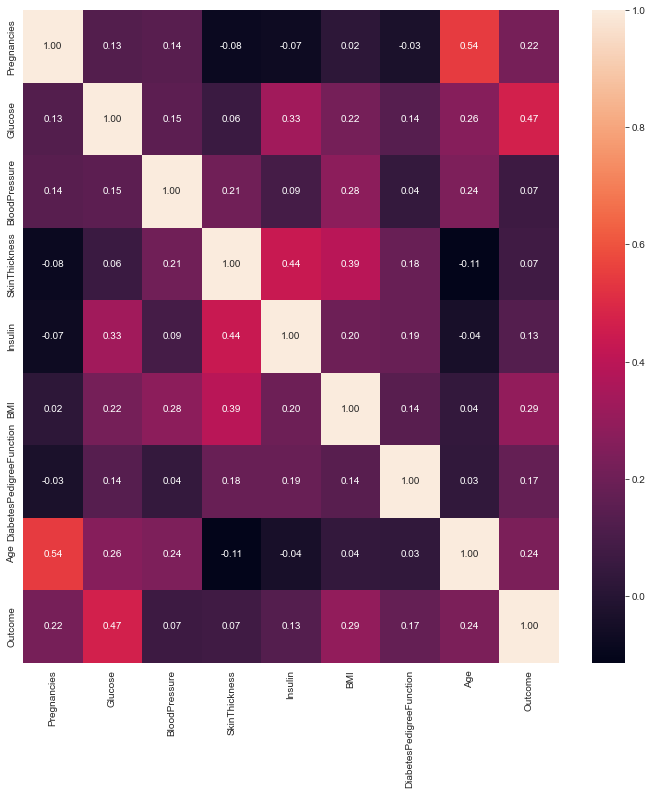

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(data_correlation, annot=True, fmt='.2f')
plt.show()

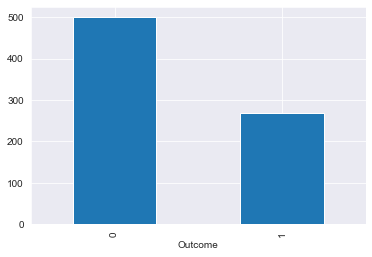

In [10]:
data.Outcome.value_counts().plot(kind='bar')
plt.show()

In [11]:
y = data['Outcome']
X = data.drop('Outcome', axis=1)

In [14]:
from sklearn.cluster import MiniBatchKMeans

sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)
X, y = sm.fit_resample(X, y)

In [15]:
y.value_counts()

Outcome
1    502
0    500
Name: count, dtype: int64

In [16]:
# Normalizar
y /= np.max(y)
X /= np.max(X, axis=0)

In [17]:
X[:5], y[:5]

(   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
 0     0.352941  0.743719       0.590164       0.353535  0.000000  0.500745   
 1     0.058824  0.427136       0.540984       0.292929  0.000000  0.396423   
 2     0.470588  0.919598       0.524590       0.000000  0.000000  0.347243   
 3     0.058824  0.447236       0.540984       0.232323  0.111111  0.418778   
 4     0.000000  0.688442       0.327869       0.353535  0.198582  0.642325   
 
    DiabetesPedigreeFunction       Age  
 0                  0.259091  0.617284  
 1                  0.145041  0.382716  
 2                  0.277686  0.395062  
 3                  0.069008  0.259259  
 4                  0.945455  0.407407  ,
 0    1.0
 1    0.0
 2    1.0
 3    0.0
 4    1.0
 Name: Outcome, dtype: float64)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0 ,test_size=0.2)

In [19]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)


X_train:  (801, 8)
X_test:  (201, 8)
y_train:  (801,)
y_test:  (201,)


## MLPClassifier

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

def MLP(train_x, train_y, test_x, test_y, n_neurons):
    reg = MLPClassifier(hidden_layer_sizes=(n_neurons,n_neurons,n_neurons), activation="relu" ,random_state=1, max_iter=200).fit(train_x, train_y)
    y_pred=reg.predict(test_x)

    model_accuracy = round(accuracy_score(test_y, y_pred),2)
    #confusion matrix
    cm = confusion_matrix(test_y, y_pred)
    return model_accuracy,cm, y_pred

In [21]:
accuracy, conf_marix, y_pred = MLP(X_train, y_train, X_test, y_test, 512)
print("Model Accuracy:" + str(accuracy) + "\n" + "Confusion Matrix:\n" + str(conf_marix))

Model Accuracy:0.87
Confusion Matrix:
[[83 17]
 [ 9 92]]


## Sequencial

In [22]:
import tensorflow as tf

In [23]:
def NN(train_x, train_y, test_x, test_y, n_neurons):
    
    tf.random.set_seed(2)
    
    new_train_x, x_val, new_train_y, y_val = train_test_split(train_x, train_y, test_size = 0.2, random_state = 13)

    NN_model = keras.Sequential([
        keras.layers.Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(n_neurons, activation='relu'),
        keras.layers.Dense(n_neurons, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
    )
    
    
    train_history = NN_model.fit(
    new_train_x, new_train_y,
    validation_data=(x_val, y_val),
    batch_size = 8,
    shuffle=True,
    epochs = 30,
    verbose = 0
    )
    
    pred_es = NN_model.predict(test_x)
    pred_novo = [np.round(i[0]) for i in pred_es]
    results = NN_model.evaluate(test_x, test_y)
    accuracy = accuracy_score(test_y, pred_novo)
    cm = confusion_matrix(test_y, pred_novo)

    return results, accuracy, cm, train_history, pred_es

In [24]:
results, accuracy, cm, train_history, pred_es = NN(X_train, y_train, X_test, y_test, 512)
print("\nModel Accuracy:" + str(round(results[1], 2)))
print("\nModel Accuracy:" + str(round(accuracy, 2)))
print("\nConfusion Marix:\n" + str(cm))

7/7 [==============================] - 0s 5ms/step - loss: 0.2992 - accuracy: 0.8756

Model Accuracy:0.88

Model Accuracy:0.88

Confusion Marix:
[[88 12]
 [13 88]]


In [27]:
X_train, X_test

(     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
 465     0.000000  0.623116       0.459016       0.131313  0.124113  0.324888   
 399     0.176471  0.969849       0.573770       0.313131  0.000000  0.520119   
 511     0.000000  0.698492       0.508197       0.171717  0.248227  0.329359   
 818     0.294118  0.839196       0.516393       0.000000  0.000000  0.489615   
 952     0.176471  0.743719       0.745902       0.424242  0.000000  0.738235   
 ..           ...       ...            ...            ...       ...       ...   
 835     0.411765  0.904523       0.688525       0.000000  0.000000  0.594403   
 192     0.411765  0.798995       0.540984       0.000000  0.000000  0.453055   
 629     0.235294  0.472362       0.532787       0.222222  0.000000  0.368107   
 559     0.647059  0.427136       0.606557       0.000000  0.000000  0.448584   
 684     0.294118  0.683417       0.672131       0.000000  0.000000  0.000000   
 
      DiabetesPedigreeFunc

In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Acurácia:' + str(round(accuracy_score(y_test, y_pred),2)))
print(classification_report(y_test, y_pred))

Acurácia:0.89
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       100
         1.0       0.89      0.88      0.89       101

    accuracy                           0.89       201
   macro avg       0.89      0.89      0.89       201
weighted avg       0.89      0.89      0.89       201



## XGBoost

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [31]:
# Predizendo dados 
y_pred = xgb.predict(X_test)

# Verificando modelo
print('Acurácia:' + str(round(accuracy_score(y_test, y_pred),2)))
print(classification_report(y_test, y_pred))

Acurácia:0.86
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86       100
         1.0       0.85      0.88      0.86       101

    accuracy                           0.86       201
   macro avg       0.86      0.86      0.86       201
weighted avg       0.86      0.86      0.86       201



In [33]:
feature_names = X_train.columns

In [34]:
xgb.get_booster().feature_names = list(feature_names.values)

In [35]:
xgb.get_booster().feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [36]:
from xgboost import plot_importance

<Figure size 1008x504 with 0 Axes>

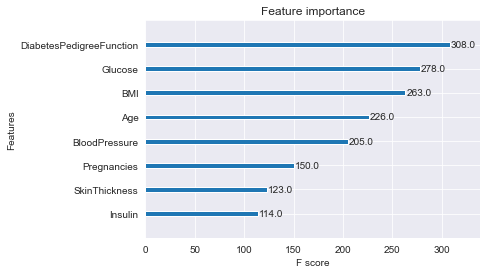

In [38]:
plt.figure(figsize=(14,7))
plot_importance(xgb)
plt.show()